# Verify the weight of u+p

## Prepare environment and  define parameters 

In [1]:
is_colab = False
import sys
if is_colab:
    !pip install -q torch==1.8.1
    !pip install -q torchvision==0.4.0
    !pip install -q qiskit==0.14.0
    !pip install qfnn


import torch
import torchvision

import qiskit
from qiskit import  QuantumCircuit, ClassicalRegister
import numpy as np
import functools

sys.path.append('../')
from src.qfnn.qf_fb.q_output import fire_ibmq,analyze,add_measure
from src.qfnn.qf_circ.n_lyr_circ import N_LYR_Circ
from src.qfnn.qf_circ.u_lyr_circ import U_LYR_Circ
from src.qfnn.qf_circ.p_lyr_circ import P_LYR_Circ
from src.qfnn.qf_fb.c_input import load_data,to_quantum_matrix
from src.qfnn.qf_net.utils import binarize

print = functools.partial(print, flush=True)






## Load data

In [2]:

################ Zhirui on 12-30-2020 ################
# Parameters of settings
######################################################
interest_num = [3,6]
img_size = 4
 # how many samples per batch 
batch_size = 32
inference_batch_size = 1


################ Zhirui on 12-30-2020 ################
# path
######################################################
if is_colab:
    data_path = '/content/data' #mnist  path
else: 
    data_path = '/home/hzr/Software/quantum/qc_mnist/pytorch/data'

################ Zhirui on 12-30-2020 ################
# load data.
######################################################

train_loader, test_loader = load_data(interest_num,data_path,False,img_size,batch_size,inference_batch_size,False)
for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix = to_quantum_matrix(data)
    break

Batch Id: 0, Target: tensor([0])


## Inference

In [3]:
################ Weiwen on 12-30-2020 ################
# Parameters of the trained model
# The training procedure will be found in another repo
# https://github.com/weiwenjiang/QuantumFlow
######################################################
import math
# Model initialization
# weight_1 = torch.tensor([[1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,    1.,  1.],[-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1.]])
# weight_2 = torch.tensor([[1.,  -1.],[-1.,  -1.]])
if is_colab:
    resume_path = '/content/libs/best_model/v_u.tar' #model path
else:
    resume_path = '/home/hzr/Software/quantum/JQuantumFlow_tutorial/model/u2_p2_n2/model_best.tar' #model path
checkpoint = torch.load(resume_path, map_location='cpu')
print(checkpoint['state_dict']['fc0.weight'])
print(checkpoint['state_dict']['fc1.weight'])
print(checkpoint['state_dict']['fc2.batch.x_l_0_5'])
print(checkpoint['state_dict']['fc2.batch.x_g_0_5'])

weight_1 = checkpoint['state_dict']['fc0.weight']
weight_2 = checkpoint['state_dict']['fc1.weight']
norm_flag = checkpoint['state_dict']['fc2.batch.x_l_0_5']
norm_para = checkpoint['state_dict']['fc2.batch.x_running_rot']
print(norm_para)


tensor([[ 3.5105,  3.8705,  3.3005,  1.8863,  2.2311,  2.7561,  4.0765,  1.6433,
          1.5009, -4.4550,  1.9780, -2.7938,  4.0159,  4.3327,  3.8757,  3.5464],
        [-4.0358, -4.2721, -2.5927, -0.1222, -2.3137, -2.5985, -4.4511, -0.0303,
         -0.7217,  4.4245, -0.0181,  2.8718, -4.0845, -4.1506, -4.2319, -3.4403]])
tensor([[ 4.9824, -4.7698],
        [-4.8631, -4.9328]])
tensor([1., 0.])
tensor([0., 1.])
tensor([0.2714, 0.7285])


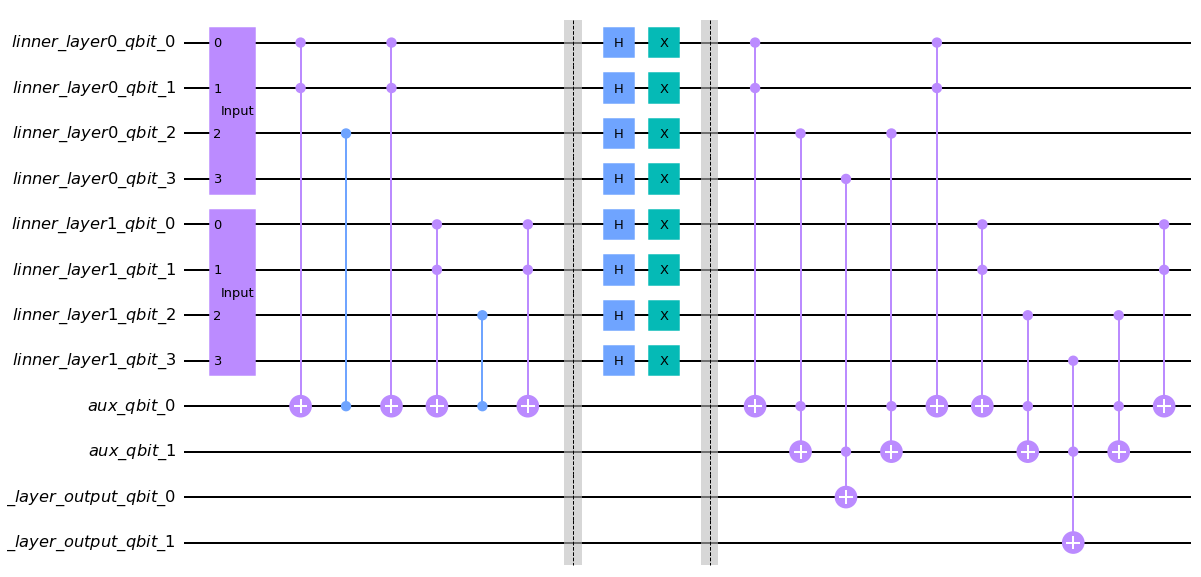

In [4]:
################ Weiwen on 12-30-2020 ################
# Generate the circuit of u-layer
######################################################
#define your input and output number
u_layer = U_LYR_Circ(4,2) 
#init circuit
circuit = QuantumCircuit()
#add input qubit to your circuit
inps = u_layer.add_input_qubits(circuit)

#add auxiliary qubit to your circuit
aux =u_layer.add_aux(circuit)

#add output qubit to your circuit
u_layer_out_qubits = u_layer.add_out_qubits(circuit)

#add ulayer to your circuit
# print(quantum_matrix)
u_layer.forward(circuit,binarize(weight_1) ,inps,u_layer_out_qubits,quantum_matrix,aux)

#show your circuit
if is_colab:
    layout = 'text'
    fold = 300
else:
    layout = 'mpl'
    fold = 300

circuit.draw(layout,fold=fold)



Output layer created!


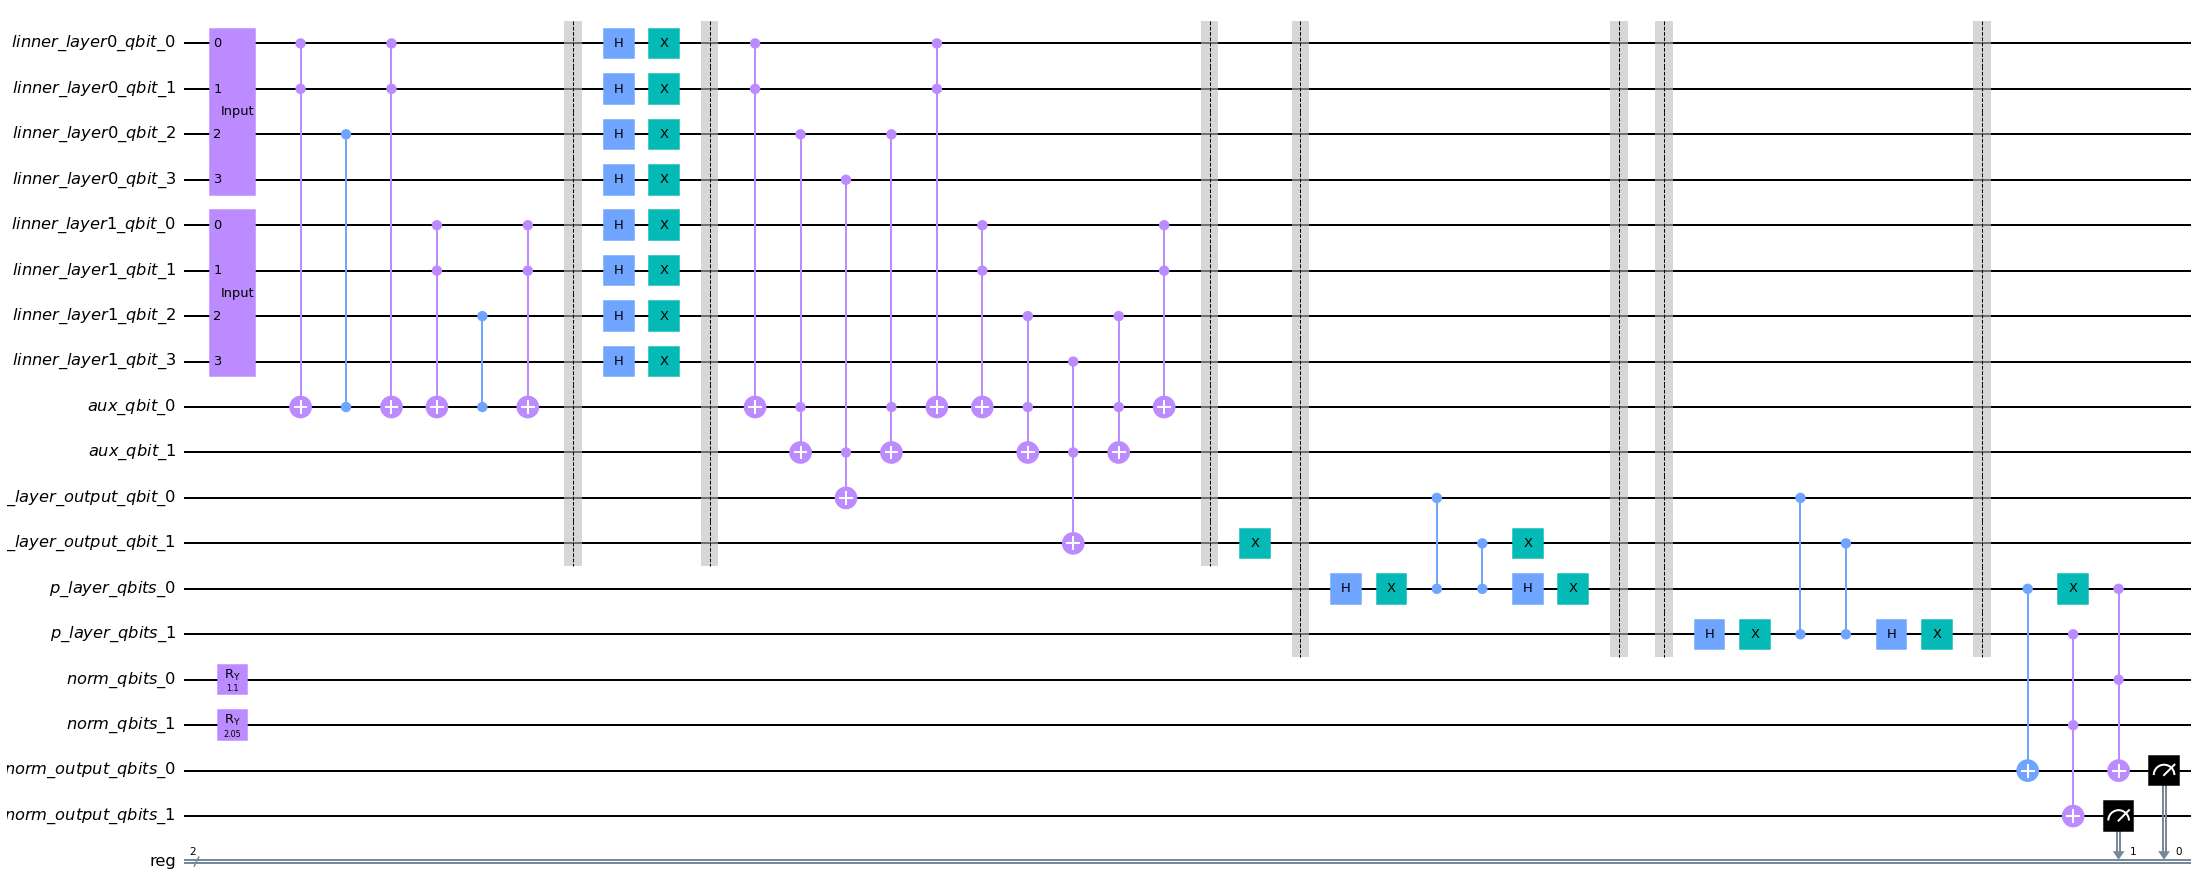

In [5]:
################ Weiwen on 12-30-2020 ################
# Quantum circuit implementation of the output layer
# fundamentals, please see our Nature Communication
# paper (P-LYR) https://arxiv.org/pdf/2006.14815.pdf
######################################################

circuit.barrier()
p_layer = P_LYR_Circ(2,2)


p_aux = p_layer.add_aux(circuit,"p_aux")
p_layer_output = p_layer.add_out_qubits(circuit)
p_layer.forward(circuit,binarize(weight_2),u_layer_out_qubits,p_layer_output,p_aux)


norm = N_LYR_Circ(2)
norm_qubit = norm.add_norm_qubits(circuit)
norm_output_qubit = norm.add_out_qubits(circuit)
norm.forward(circuit,p_layer_output,norm_qubit,norm_output_qubit,norm_flag,norm_para)


add_measure(circuit,norm_output_qubit,'reg')

print("Output layer created!")

circuit.draw('mpl',fold =50)

### Non-Optimized Circuit v.s. Optimized Circuit

Let's test and compare!


In [6]:
################ Weiwen on 12-30-2020 ################
# Quantum simulation
######################################################

# Optimized one
qc_shots=8192
opt_counts = fire_ibmq(circuit,qc_shots,True)
print("="*10,"Optimized Circuit","="*10)
(opt_mycount,bits) = analyze(opt_counts)
opt_class_prob=[]
for b in range(bits):
    opt_class_prob.append(float(opt_mycount[b])/qc_shots)


print("="*10,"Optimized Circuit","="*10)
print("Optimized Circuit Depth:",circuit.depth())
print("Result of optimized QC:",opt_class_prob)
print("Prediction class: {}".format(opt_class_prob.index(max(opt_class_prob))))
print("Target class: {}".format(target[0]))
if opt_class_prob.index(max(opt_class_prob))==target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")
print("="*30)

========== Optimized Circuit ==========
========== Optimized Circuit ==========
Optimized Circuit Depth: 36
Result of optimized QC: [0.5892333984375, 0.4117431640625]
Prediction class: 0
Target class: 0
Correct prediction


In [7]:
from src.qfnn.qf_fb.c_qf_mixer import Net
from src.qfnn.qf_fb.c_input import ToQuantumData
neural_in_layers = 'u:2,p:2,n:2'
layers = []
for item1 in neural_in_layers.split(","):
    x= item1.split(":")
    layer =[]
    layer.append(x[0].strip())
    layer.append(int(x[1].strip()))
    layers.append(layer)
given_ang =[]
given_ang.append([])
given_ang.append([])
given_ang.append(norm_para)
print(given_ang)
print("layers:",layers)
model = Net(img_size,layers,False,False,given_ang,False)
model.load_state_dict(checkpoint["state_dict"])
# print(quantum_matrix)
to_quantum_data = ToQuantumData(img_size)
output_data = to_quantum_data(data)
output = model.forward(output_data,False)
print(output)

[[], [], tensor([0.2714, 0.7285])]
layers: [['u', 2], ['p', 2], ['n', 2]]
tensor([[0.5763, 0.3934]], grad_fn=<MulBackward0>)


/home/hzr/Software/quantum/JQuantumFlow_tutorial/tests/../src/qfnn/qf_net/n_lyr.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ang_inc = Parameter(torch.tensor(init_ang_inc,dtype=torch.float32),requires_grad=True)
